In [14]:
import pandas as pd
import pyarrow

from collections import defaultdict
from datetime import datetime

from sklearn.preprocessing import RobustScaler, QuantileTransformer
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pylab

import io
import re
from glob import iglob

%matplotlib inline
pylab.rcParams['image.cmap'] = 'viridis'
pylab.rcParams['figure.figsize'] = (35.0, 12.0)
# pylab.rcParams['figure.figsize'] = (100, 100)
pylab.rcParams['figure.dpi'] = 300
pylab.rcParams['font.size'] = 25

In [15]:
sample_iperf_out = io.StringIO("""
[  5] local ::1 port 35478 connected to ::1 port 7001
[ ID] Interval           Transfer     Bitrate         Retr  Cwnd
[  5]   0.00-1.01   sec  97.5 MBytes   811 Mbits/sec    0   4.06 MBytes
[  5]   1.01-2.01   sec  77.5 MBytes   649 Mbits/sec    0   4.06 MBytes
[  5]   2.01-3.00   sec  98.8 MBytes   837 Mbits/sec    0   4.06 MBytes
[  5]   3.00-4.00   sec   138 MBytes  1.15 Gbits/sec    0   4.06 MBytes
[  5]   4.00-5.00   sec   185 MBytes  1.56 Gbits/sec    0   4.06 MBytes
[  5]   5.00-6.00   sec   191 MBytes  1.60 Gbits/sec    0   4.06 MBytes
[  5]   6.00-7.00   sec   144 MBytes  1.21 Gbits/sec    0   4.06 MBytes
[  5]   7.00-8.00   sec  43.8 MBytes   367 Mbits/sec    0   4.06 MBytes
[  5]   8.00-9.00   sec  66.2 MBytes   556 Mbits/sec    0   4.06 MBytes
[  5]   9.00-10.00  sec  82.5 MBytes   692 Mbits/sec    0   4.06 MBytes
[ ID] Interval           Transfer     Bitrate         Retr
[  5]   0.00-10.00  sec  1.10 GBytes   943 Mbits/sec    0             sender
[  5]   0.00-10.03  sec  1.09 GBytes   932 Mbits/sec                  receiver
""")

Existing CSV/JSON parsers broken for iperf3

https://github.com/esnet/iperf/blob/master/contrib/iperf3_to_gnuplot.py

https://gist.github.com/mtarsel/04bb3f18d1a5336b764e

DIY iperf3 parser

In [16]:
iperf3_tbl = defaultdict(list)

for file in iglob('data/*.log'):
    filename_dateparse = pd.datetime.strptime(file, 'data/%Y-%m-%dT%H:%M.log')
    iperf3_tbl['datetime'].append(filename_dateparse)
    with open(file, 'r') as f:
        for line in f:
            header = re.search('\[\sID\]\s(\w+)\s+(\w+)\s+(\w+)\s+(\w+)', line)
            info = re.search('\[\s+5\]\s+([0-9]*\.?[0-9]+-[0-9]*\.?[0-9]+)\s+sec\s+([0-9]*\.?[0-9]+)\s([M|G|K]Bytes)\s+([0-9]*\.?[0-9]+)\s+(\w+/sec)\s+\d+\s+[0-9]*\.?[0-9]+\s+([M|G|K]Bytes)', line)
            receiver = re.search('\[\s+5\]\s+([0-9]*\.?[0-9]+-[0-9]*\.?[0-9]+)\s+sec\s+([0-9]*\.?[0-9]+)\s([M|G|K]Bytes)\s+([0-9]*\.?[0-9]+)\s+(\w+/sec)\s+receiver', line)
            sender =   re.search('\[\s+5\]\s+([0-9]*\.?[0-9]+-[0-9]*\.?[0-9]+)\s+sec\s+([0-9]*\.?[0-9]+)\s([M|G|K]Bytes)\s+([0-9]*\.?[0-9]+)\s+(\w+/sec)\s+[0|1]\s+sender', line)
            if header:
                pass
            if info:
                pass
            if receiver:
                if receiver.group(3) == 'GBytes':
                    iperf3_tbl["bitrate_receiver"].append(float(receiver.group(4)))
                else:
                    iperf3_tbl["bitrate_receiver"].append(float(receiver.group(4))/1024)
            if sender:
                if sender.group(3) == 'GBytes':
                    iperf3_tbl["bitrate_sender"].append(float(sender.group(4)))
                else:
                    iperf3_tbl["bitrate_sender"].append(float(sender.group(4))/1024)

In [17]:
assert(len(iperf3_tbl['bitrate_receiver']) == len(iperf3_tbl['bitrate_sender']) == len(iperf3_tbl['datetime']))

In [18]:
iperf3_df = pd.DataFrame(iperf3_tbl)
iperf3_df = iperf3_df.set_index(pd.DatetimeIndex(iperf3_df['datetime']))
del iperf3_df['datetime']

Save it in Arrow

In [19]:
# XXX: https://twitter.com/braincode/status/921383742891061248
#table = pa.Table.from_pandas(iperf3_df)
#table_serialized = pyarrow.serialize(table).to_buffer()
#with open('iperf3.data') as f:
#    f.write(table_serialized)

Deserialize if you want to use it (uncomment)

In [20]:
#with open('iperf3_data') as f:
#    table_deserialized = pyarrow.deserialize(f.read())
#    iperf3_df = table_deserialized.to_pandas()

In [21]:
iperf3_df.describe()

,bitrate_receiver,bitrate_sender
count,205.000000,205.000000
mean,9.849373,14.186712
std,93.970246,112.289169
min,0.190430,0.199219
25%,0.280273,0.289062
50%,0.375977,0.384766
75%,0.707031,0.716797
max,976.000000,987.000000


In [22]:
# Normalize this a bit..
scaler = QuantileTransformer() 
scaled_values = scaler.fit_transform(iperf3_df) 
iperf3_df.loc[:,:] = scaled_values

In [23]:
iperf3_df.describe()

,bitrate_receiver,bitrate_sender
count,2.050000e+02,2.050000e+02
mean,4.999958e-01,4.999963e-01
std,2.907997e-01,2.908065e-01
min,1.000000e-07,1.000000e-07
25%,2.522523e-01,2.497497e-01
50%,5.001668e-01,5.001668e-01
75%,7.498551e-01,7.498407e-01
max,9.999999e-01,9.999999e-01


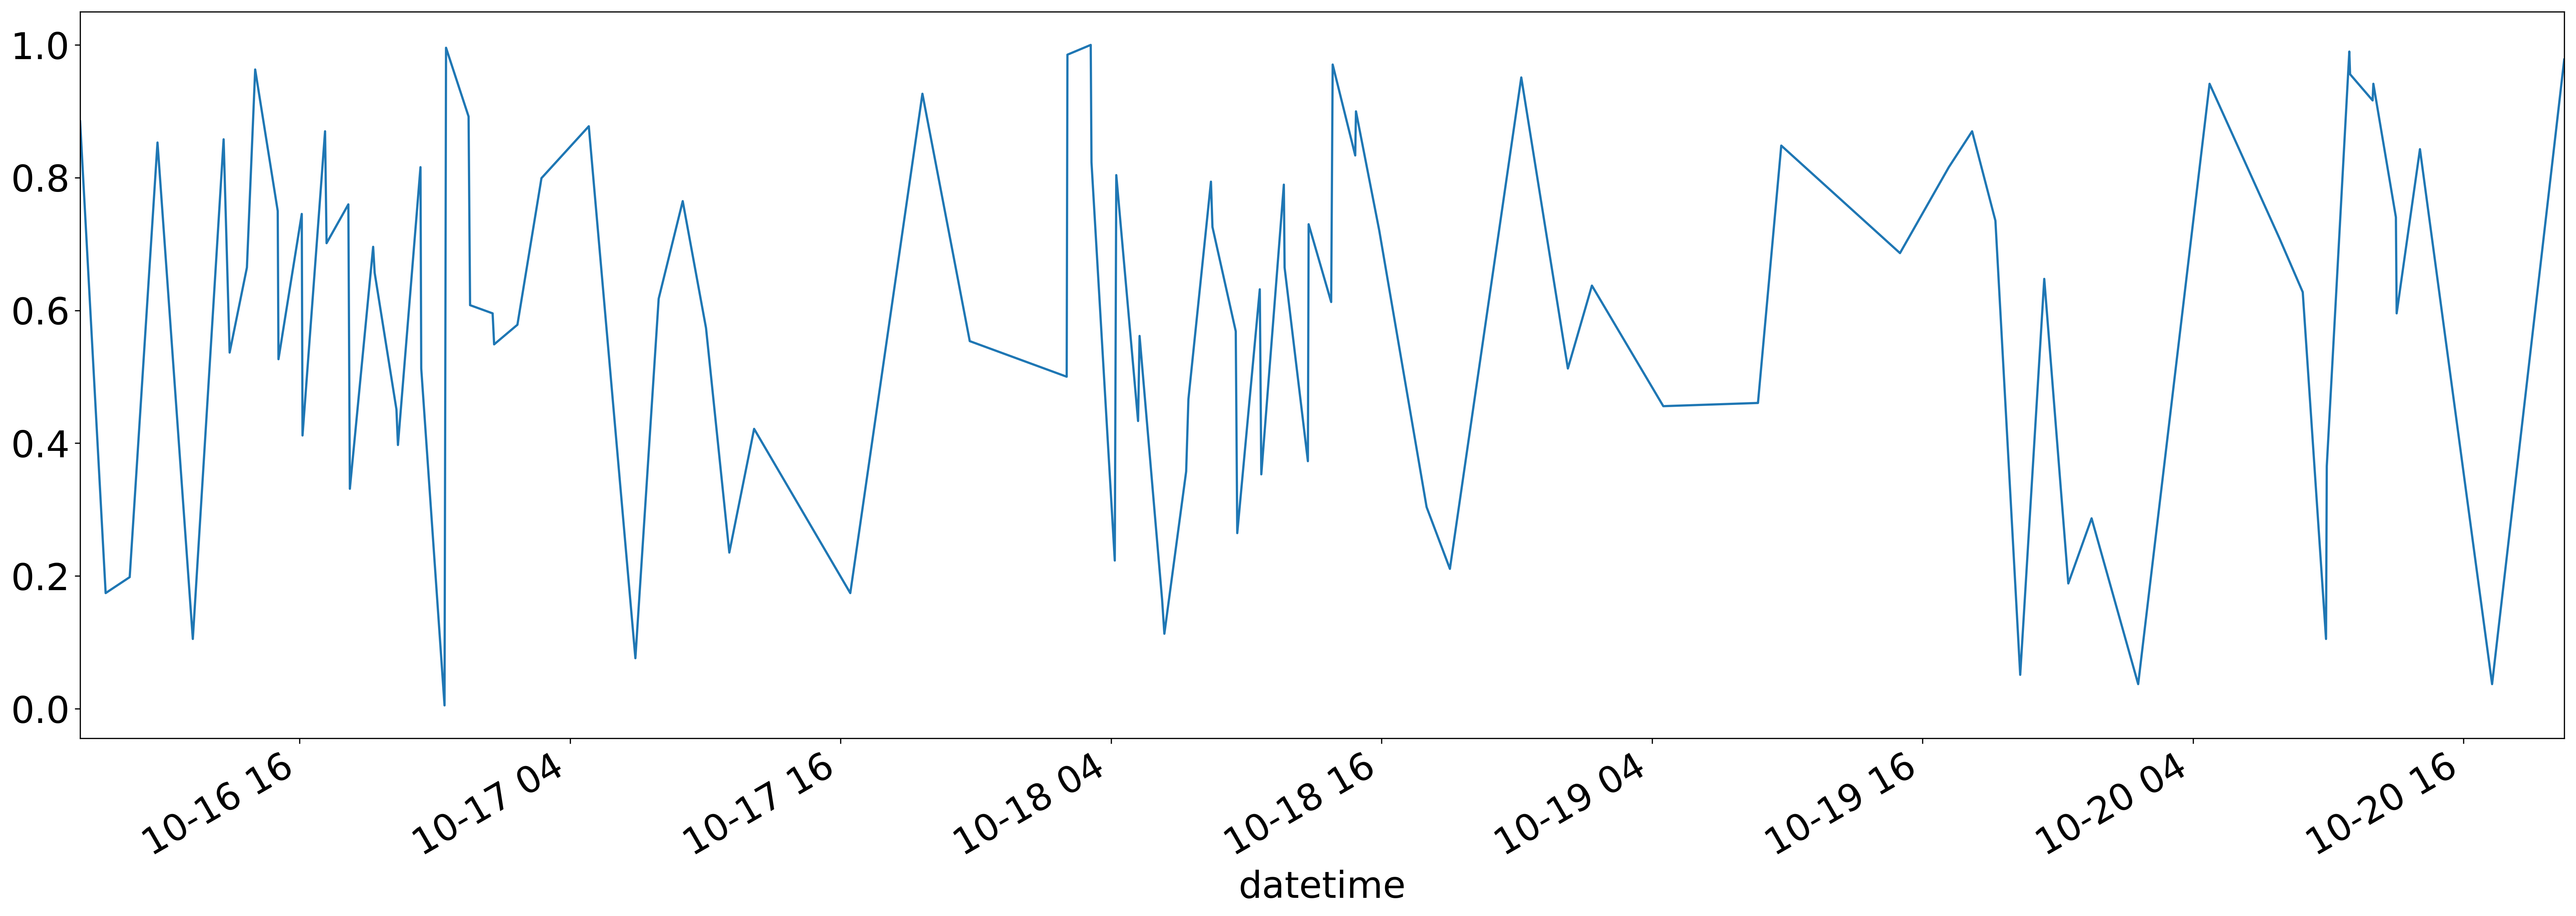

In [24]:
iperf3_df['20171016':].bitrate_receiver.plot(figsize=(30,10))